In [1]:
import torch
import torch.nn as nn

import torchvision
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

### Load saved state dicts onto the pretrained VGG-19 model

In [2]:
from torchvision import models
pretrained_vgg19 = models.vgg19(pretrained=True)

In [3]:
# Loading the state dict into our model
state_dict = torch.load('vgg16_4000Iterations.pth',map_location='cuda:0')

from torchvision import models
model = models.vgg19(pretrained=True)
model.classifier[-1] = nn.Linear(in_features=4096, out_features=11)

model.load_state_dict(state_dict)

<All keys matched successfully>

###  Loop over the layers of the network and apply the metric functions on the conv layers  

- Here, the  the norm difference, cosine simularity, and sparsity between the corresponding conv layers is calculated.
- f1 refers to a convolutional layer in the network pretrained on the ImageNet dataset.
- f2 refers to the a convolutional layer in the network pretraiend on the CL-20 target dataset.

In [4]:
diff = []
sparsity = []
with torch.no_grad():
    for k in [0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]:
        f1 = pretrained_vgg19.features[k].weight
        f2 = model.features[k].weight
        
        # Sparsity calculation
        comp = abs(f1) <= 5e-2*torch.ones(list(f1.shape))
        total = torch.sum(comp)
        all = torch.sum(torch.ones(list(f1.shape)))
        s = total/all*100
        
        # Norm difference calculation
        d = (torch.norm(f1-f2).numpy())/torch.norm(f1)*100
        
        # Appending
        diff.append(d)
        sparsity.append(s)
        

with torch.no_grad():
    for k in [0, 3]:
        f1 = pretrained_vgg19.classifier[k].weight
        f2 = model.classifier[k].weight
        
        # Sparsity calculation
        comp = abs(f1) <= 5e-2*torch.ones(list(f1.shape))
        total = torch.sum(comp)
        all = torch.sum(torch.ones(list(f1.shape)))
        s = total/all*100
        
        # Norm difference calculation
        d = (torch.norm(f1-f2).numpy())/torch.norm(f1)*100
        
        # Appending
        diff.append(d)
        sparsity.append(s)

In [5]:
## Cosine Similarity Function
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

cos_sim = []
with torch.no_grad():
    for k in [0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]:
        f1 = pretrained_vgg19.features[k].weight
        f2 = model.features[k].weight

        nf1 = f1.view(1,-1)
        nf2 = f2.view(1,-1)
       
        c = cos(nf1, nf2).numpy()
        cos_sim.append(c)

with torch.no_grad():
    for k in [0, 3]:
        f1 = pretrained_vgg19.classifier[k].weight
        f2 = model.classifier[k].weight
        
        nf1 = f1.view(1,-1)
        nf2 = f2.view(1,-1)

        c = cos(nf1, nf2).numpy()
        cos_sim.append(c)

Text(0, 0.5, 'norm diff')

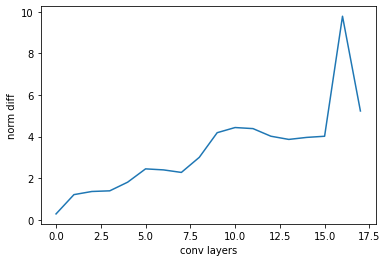

In [13]:
plt.plot(diff)
plt.xlabel('conv layers')
plt.ylabel('norm diff')

Text(0, 0.5, 'cos similarity')

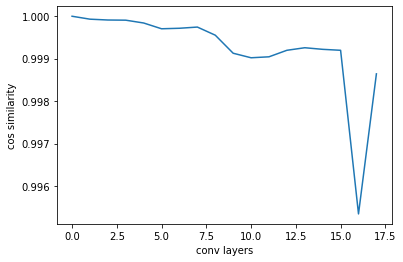

In [14]:
plt.plot(cos_sim)
plt.xlabel('conv layers')
plt.ylabel('cos similarity')

Text(0, 0.5, 'sparsity')

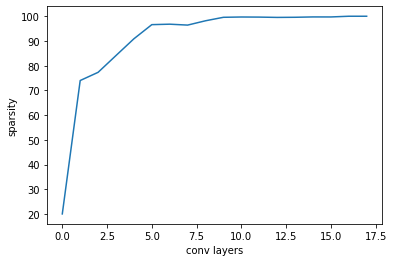

In [15]:
plt.plot(sparsity)
plt.xlabel('conv layers')
plt.ylabel('sparsity')

### Saver the results

In [10]:
from numpy import savetxt

normdiff = np.array(diff)
cos_sim = np.array(cos_sim)
sparsity = np.array(sparsity)

savetxt('1_normdiff_vgg19.csv', normdiff, delimiter=',')
savetxt('1_cos_sim_vgg19.csv', cos_sim, delimiter=',')
savetxt('1_sparsity_vgg19.csv', sparsity, delimiter=',')
